## Twitter sentiment Analysis


### Project Overview

In a dynamic digital landscape, understanding public sentiment towards technology giants like Apple and Google is paramount. This project aims to harness the power of Natural Language Processing (NLP) to conduct a comprehensive sentiment analysis of tweets related to their products. By leveraging a dataset containing over 9,000 manually annotated tweets, we seek to create a robust model that discerns sentiments as positive, negative, or neutral. The multifaceted nature of this analysis offers valuable insights for businesses, marketing strategists, and researchers invested in the consumer electronics domain.

### Business Understanding

In the era of social media dominance, the reputation and perception of tech companies can be heavily influenced by user-generated content. Understanding the sentiment expressed on platforms like Twitter provides a unique opportunity to gauge public perception, inform strategic decisions, and enhance customer engagement strategies. By delving into the sentiment surrounding Apple and Google products, businesses can gain actionable insights, refine their marketing approaches, and maintain a pulse on the evolving consumer landscape.

### Objectives:

1. Initiate the project with a focused binary classifier to distinguish positive and negative sentiments. Gradually extend the model's capabilities to handle neutral sentiments, ensuring a robust multiclass classification system(Proof of Concept).

2. Develop a sophisticated NLP model capable of accurately classifying tweet sentiments as positive, negative, or neutral, providing nuanced insights into the public's opinions(Sentiment Analysis).

3. Continuously refine the model's architecture and parameters, drawing inspiration from advanced NLP techniques documented in the Mod 4 Appendix. This iterative approach ensures optimal performance and adaptability to the evolving landscape of social media language(Model Iteration)


Importing the necessary libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re

%matplotlib inline

Functions used in the project:

In [2]:
def load_csv_to_dataframe(file_path):
    """
    Load a CSV file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    df = pd.read_csv(file_path, encoding='latin-1')
    return df

def dataframe_preview(dataframe):
    #To get the shape of the dataframe
    print("The shape of the dataframe:")
    print(dataframe.shape)
    print('\n')
    #Describe the dataframe
    print("Describing the dataframe:")
    print(dataframe.describe())
    print('\n')
    #checking the columns in the dataset
    print("Columns in the dataset:")
    print(dataframe.columns)
    print('\n')
    #To get the info of the dataframe
    print("The data in the dataframe:")
    print(dataframe.info())
    print('\n')

def clean_tweet_text(text):
    try:
        cleaned_text = re.sub(r'@\w+', '', str(text))
        cleaned_text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', cleaned_text)
        cleaned_text = cleaned_text.encode('ascii', 'ignore').decode()
        return cleaned_text
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

def extract_hashtag_words(text):
    try:
        hashtags = re.findall(r'#(\w+)', text)
        h = ''
        for hashtag in hashtags:
            h += str(hashtag) + ','
        return h.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text



## Data understanding

### Loading data
In this section, we will upload data and conduct surface analysis whereby we will check  the shape,check for null values

In [3]:
# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'tweet_product_company.csv'

# Load the CSV file into a pandas DataFrame
df = load_csv_to_dataframe(file_path)

# Display the DataFrame
print(df)

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
0                             iPhone   
1                 iPad or iPhone App   
2                               iPad   
3                 iPad or iPhone App   
4                             Google   
...                              ...   
9088       

In [4]:
#Call function to preview the data
dataframe_preview(df)

The shape of the dataframe:
(9093, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

## Data cleaning

We will now proceed to cleaning the data.This involves removing duplicates and droping null values which were observed above. We will also try to extract all usefull information from the tweet removing unneccessary characters like usernames, links and special characters.

In [5]:
#Dropping duplicate entries in the tweet_text column
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)


In [6]:
# Check the dataframe
dataframe_preview(df)

The shape of the dataframe:
(9066, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9065   
unique                                               9065   
top     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
freq                                                    1   

       emotion_in_tweet_is_directed_at  \
count                             3280   
unique                               9   
top                               iPad   
freq                               943   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9066  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5373  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

In [7]:
#checking for total null values for each column in the dataset
missing_values = df.isnull().sum()

print(missing_values)

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5786
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [8]:
#Drop the null values
df = df.dropna(subset=['tweet_text'])

In [9]:
#Check if all missing values are dropped.
missing_values = df.isnull().sum()

print(missing_values)

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5785
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


This code uses regular expressions to replace user mentions, remove links, and non-alphanumeric characters. If you want to retain hashtags, you can uncomment the 'hashtags' line. Adjustments can be made based on specific cleaning requirements.

In [10]:
# Assuming 'df' is the DataFrame containing the dataset
df['clean_text'] = df['tweet_text'].apply(clean_tweet_text)
df['hashtags'] = df['tweet_text'].apply(extract_hashtag_words)

df['clean_text'][0]


' I have a G iPhone After  hrs tweeting at RISEAustin it was dead  I need to upgrade Plugin stations at SXSW'

In [11]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,I have a G iPhone After hrs tweeting at RISE...,"rise_austin,sxsw,"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Know about Awesome iPadiPhone app that youl...,"sxsw,"
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Can not wait for iPad also They should sale ...,"ipad,sxsw,"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,I hope this years festival isnt as crashy as ...,"sxsw,"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff on Fri SXSW Marissa Mayer Google ...,"sxsw,"


### EDA

In [12]:
# Explore 'tweet_text' column
tweet_text_distribution = df['tweet_text'].value_counts()

# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Explore 'is_there_an_emotion_directed_at_a_brand_or_product' column
emotion_directed_at_distribution = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Display the distributions
print("Distribution of 'tweet_text' values:")
print(tweet_text_distribution)

print("\nDistribution of 'emotion_in_tweet_is_directed_at' values:")
print(emotion_distribution)

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)

Distribution of 'tweet_text' values:
tweet_text
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.         1
RT @mention I think #Google lost their way by caring too much about their business (instead of their users) Tim O'Reilly #sxsw #pnid    1
RT @mention I just fell asleep for 2 hours with my eyes open, staring into the #SXSW stream on my iPad 2. {link}                        1
RT @mention I just found BBQ sauce on my iPad - tech and Texas really do come together here!  #SXSW                                     1
RT @mention I know it's #SXSW because my iPhone has started lying to me about its signal strength.                                      1
                                                                                                                                       ..
Apple Offers Up Free iTunes Sampler Ahead of #SXSW to feature new artists {link} via @mention #music                        

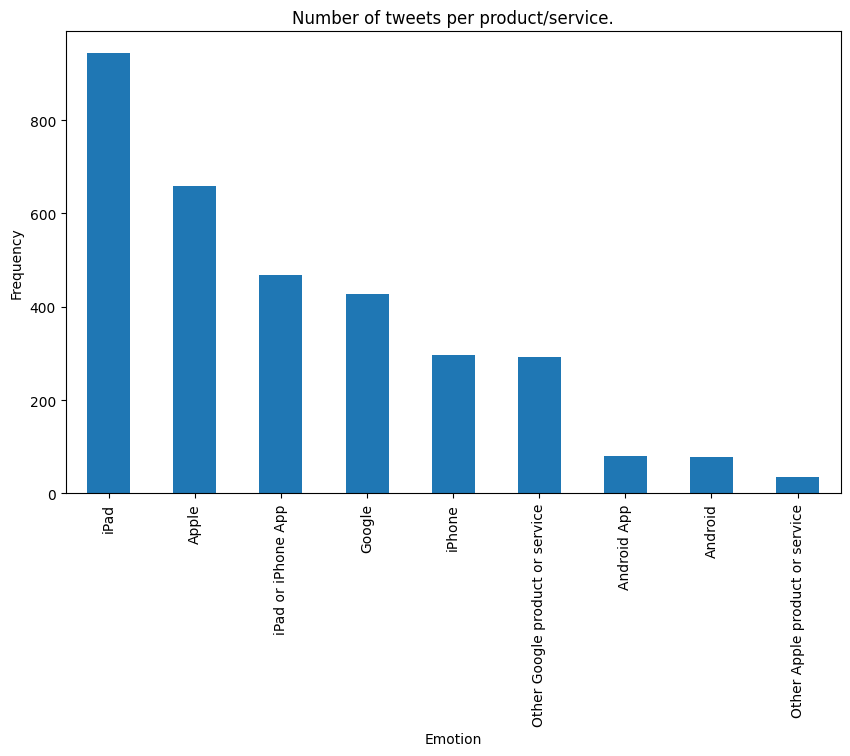

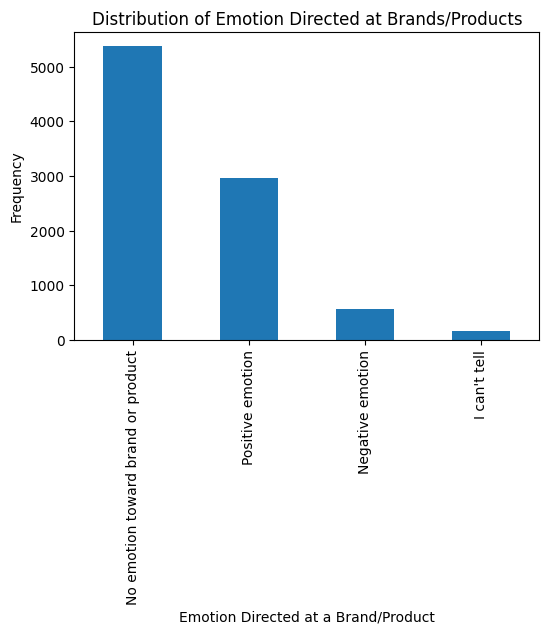

In [13]:
import matplotlib.pyplot as plt

# Bar chart for 'emotion_in_tweet_is_directed_at'
plt.figure(figsize=(10, 6))
emotion_distribution.plot(kind='bar')
plt.title('Number of tweets per product/service.')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

# Bar chart for 'is_there_an_emotion_directed_at_a_brand_or_product'
plt.figure(figsize=(6, 4))
emotion_directed_at_distribution.plot(kind='bar')
plt.title('Distribution of Emotion Directed at Brands/Products')
plt.xlabel('Emotion Directed at a Brand/Product')
plt.ylabel('Frequency')
plt.show()


In [14]:

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)


Distribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64


In [15]:
# Assuming df is your DataFrame
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({
    "I can't tell": 'Neutral emotion',
    'No emotion toward brand or product': 'Neutral emotion'
})

# Verify the changes
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: count, dtype: int64


In [16]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64

In [17]:
# Import necessary libraries
import pandas as pd

# Assuming df is your DataFrame
df['brand'] = df['emotion_in_tweet_is_directed_at'].map({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
})

# Verify the changes
print(df['brand'].value_counts())


brand
Apple     2402
Google     585
Name: count, dtype: int64


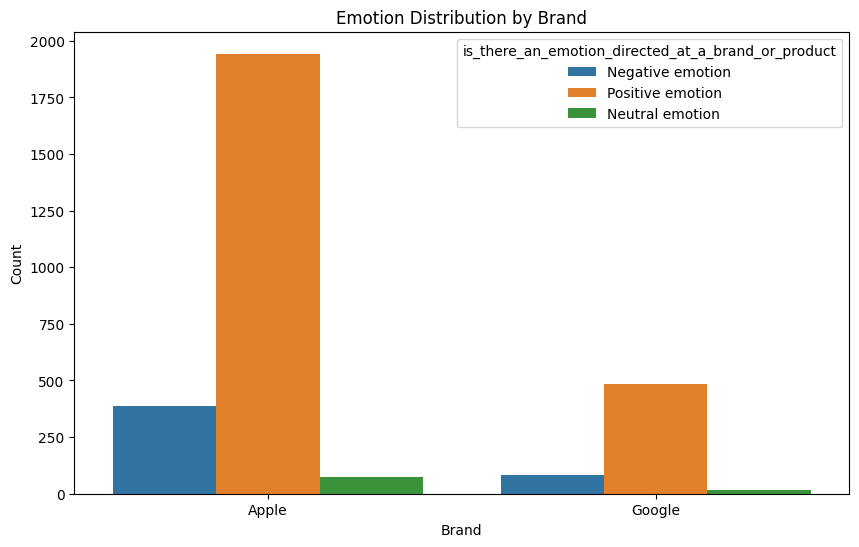

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='brand', hue='is_there_an_emotion_directed_at_a_brand_or_product', data=df)

# Add labels and title
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Emotion Distribution by Brand')

# Show the plot
plt.show()


In [19]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame and the column name is 'is_there_an_emotion_directed_at_a_brand_or_product'
column_name = 'is_there_an_emotion_directed_at_a_brand_or_product'

# Create a LabelEncoder object
enc = LabelEncoder()

# Fit and transform the specified column in the DataFrame
df[column_name] = enc.fit_transform(df[column_name])

df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
1    5528
2    2968
0     569
Name: count, dtype: int64

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df, hue='is_there_an_emotion_binary', palette={0: 'red', 1: 'green'})

# Add labels and title
plt.title('Distribution of Emotions (Binary)')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Show the legend
plt.legend(title='Binary Emotion', labels=['Negative', 'Positive'])

# Show the plot
plt.show()


ValueError: Could not interpret input 'is_there_an_emotion_binary'

<Figure size 800x600 with 0 Axes>

# * check on how can't tell and no emotion 

In [ ]:
# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

In [ ]:
print("\nDistribution of 'emotion_in_tweet_is_directed_at' values:")
print(emotion_distribution)


Distribution of 'emotion_in_tweet_is_directed_at' values:
emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64


In [ ]:
df = df.dropna(subset=['emotion_in_tweet_is_directed_at'])


In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
clean_text                                            0
hashtags                                              0
is_there_an_emotion_binary                            0
dtype: int64


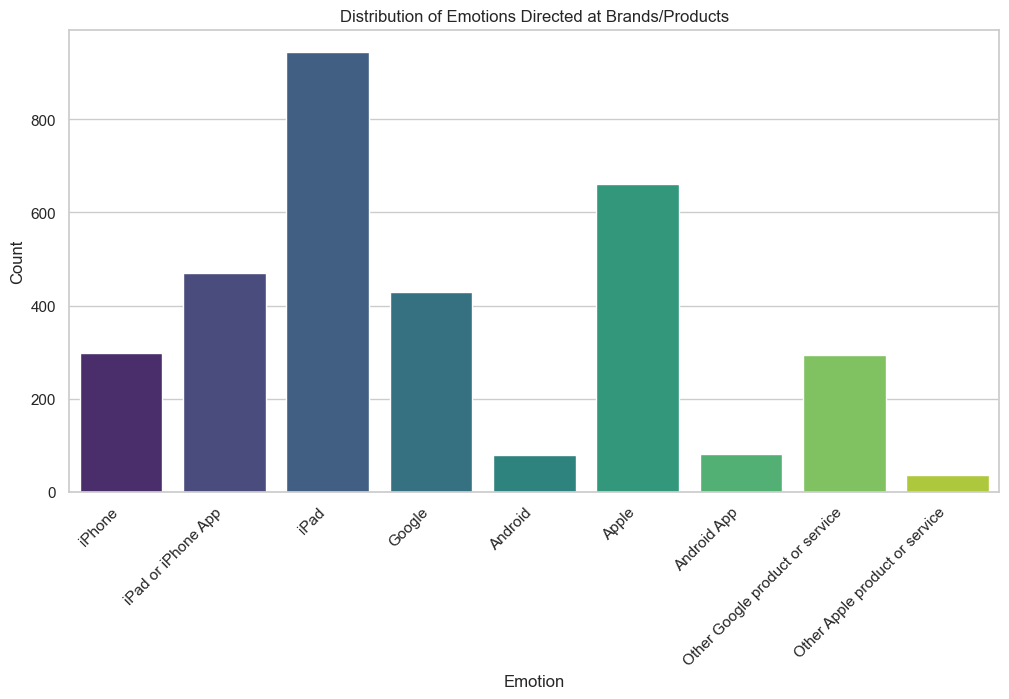

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


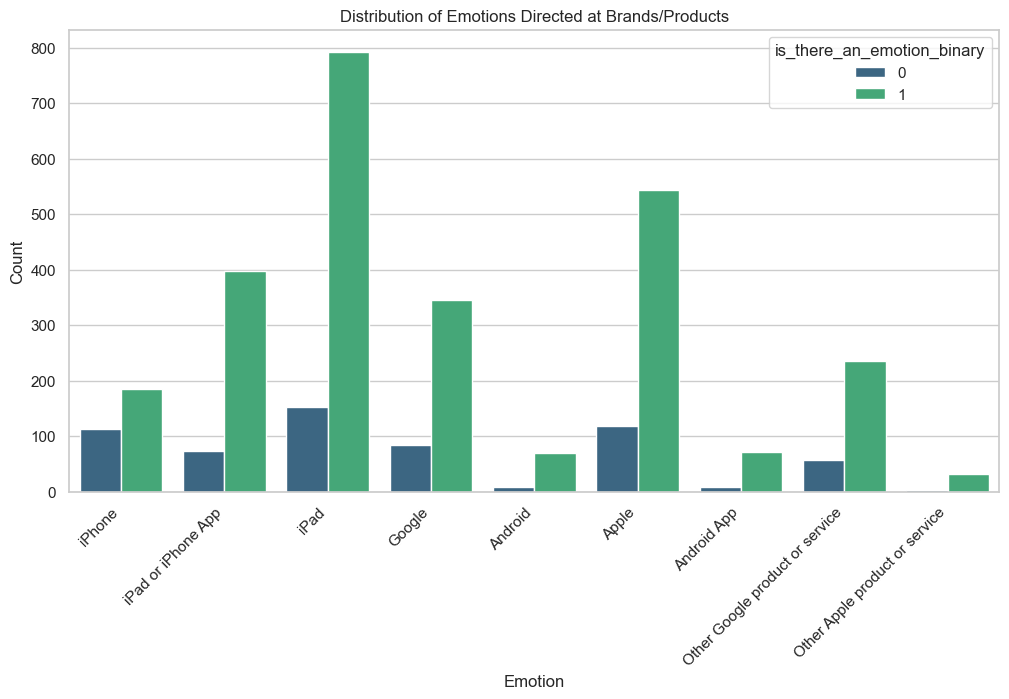

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_binary', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


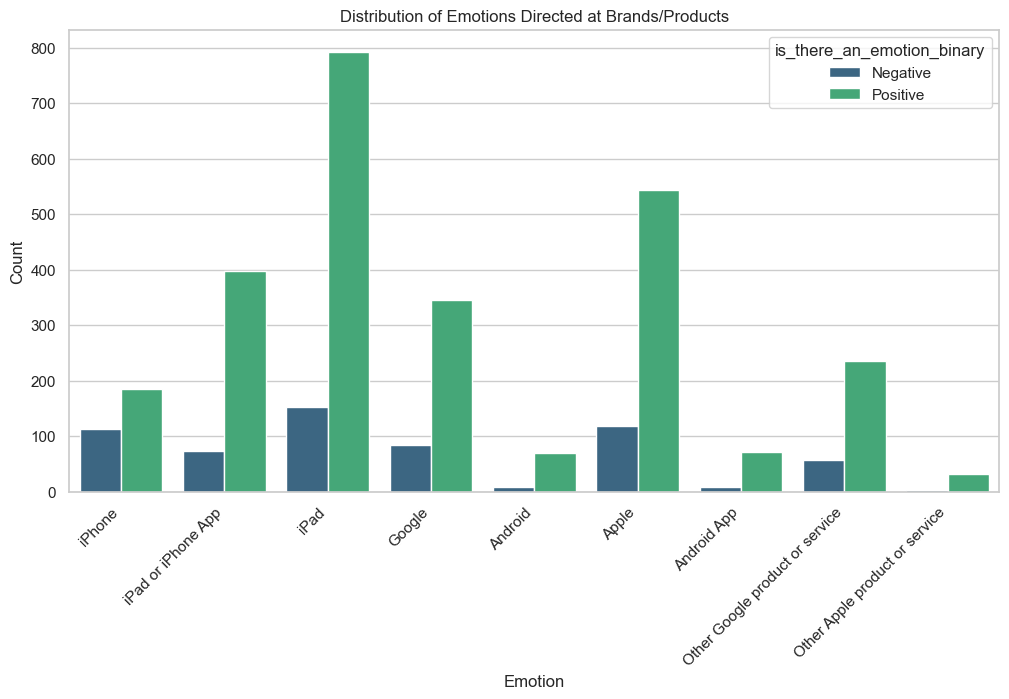

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 0 with 'Negative' and 1 with 'Positive'
df['is_there_an_emotion_binary'] = df['is_there_an_emotion_binary'].replace({0: 'Negative', 1: 'Positive'})

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_binary', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [ ]:

# Display the distributions
print("Distribution of 'tweet_text' values:")
print(tweet_text_distribution)


Distribution of 'tweet_text' values:
tweet_text
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                 5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                              4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                 4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                              3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                       2
                                                                                                                                              ..
Great interview to @mention on Bloomberg TV about #Ipad2 to kick off #SxSW.#apple 

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

# Download the required resources
nltk.download('punkt')

# Tokenize the 'tweet_text' column
df['tokenized_text'] = df['tweet_text'].apply(word_tokenize)

# Display the tokenized text
print("Tokenized Text:")
print(df['tokenized_text'])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Tokenized Text:
0       [., @, wesley83, I, have, a, 3G, iPhone, ., Af...
1       [@, jessedee, Know, about, @, fludapp, ?, Awes...
2       [@, swonderlin, Can, not, wait, for, #, iPad, ...
3       [@, sxsw, I, hope, this, year, 's, festival, i...
4       [@, sxtxstate, great, stuff, on, Fri, #, SXSW,...
                              ...                        
9077    [@, mention, your, PR, guy, just, convinced, m...
9079    [&, quot, ;, papyrus, ..., sort, of, like, the...
9080    [Diller, says, Google, TV, &, quot, ;, might, ...
9085    [I, 've, always, used, Camera+, for, my, iPhon...
9088           [Ipad, everywhere, ., #, SXSW, {, link, }]
Name: tokenized_text, Length: 3291, dtype: object


In [ ]:
from string import punctuation

# Function for further tokenization
def further_tokenize(tokens):
    # Join the tokens into a single string
    text = ' '.join(tokens)

    # Remove newline characters
    text = text.replace('\n', ' ')

    # Remove specified punctuation marks
    text = ''.join([char.lower() for char in text if char not in punctuation])

    return text

# Apply further tokenization to the 'tokenized_text' column
df['further_tokenized_text'] = df['tokenized_text'].apply(further_tokenize)

# Display the further tokenized text
print("Further Tokenized Text:")
print(df['further_tokenized_text'])


Further Tokenized Text:
0         wesley83 i have a 3g iphone  after 3 hrs twe...
1        jessedee know about  fludapp  awesome ipadiph...
2        swonderlin can not wait for  ipad 2 also  the...
3        sxsw i hope this year s festival is nt as cra...
4        sxtxstate great stuff on fri  sxsw  marissa m...
                              ...                        
9077     mention your pr guy just convinced me to swit...
9079     quot  papyrus  sort of like the ipad  quot   ...
9080    diller says google tv  quot  might be run over...
9085    i ve always used camera for my iphone bc it ha...
9088                        ipad everywhere   sxsw  link 
Name: further_tokenized_text, Length: 3291, dtype: object


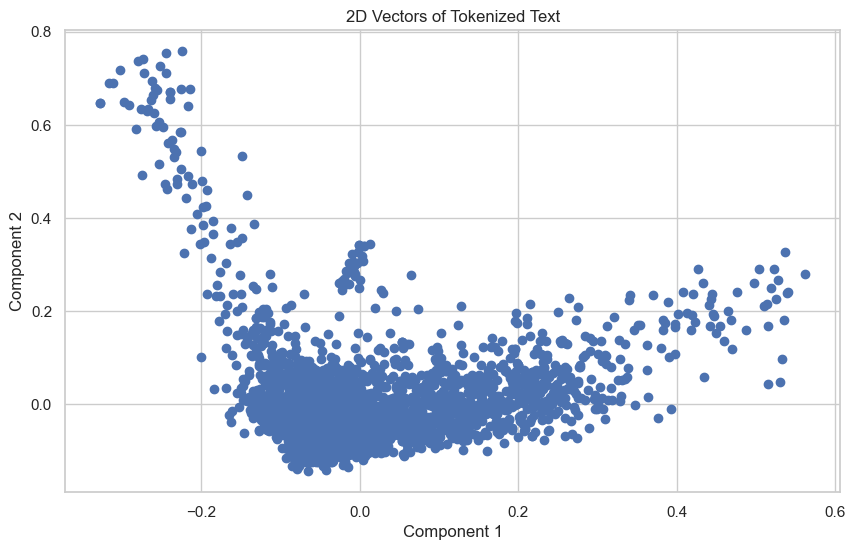

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['further_tokenized_text'])

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame for the 2D vectors
df_2d = pd.DataFrame(data=pca_result, columns=['Component 1', 'Component 2'])

# Display the 2D vectors
plt.figure(figsize=(10, 6))
plt.scatter(df_2d['Component 1'], df_2d['Component 2'])
plt.title('2D Vectors of Tokenized Text')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
